## Quantum Adiabatic Time Evolution

Imports

In [2]:
from src.hamiltonian_utils import FermiHubbardHamiltonian # the many-body Hamiltonian class
from src.nuclear_physics_utils import SingleParticleState,J2operator,get_twobody_nuclearshell_model # routines and class useful for the nuclear part
import scipy # just scipy, easy, no?
import numpy as np 
import matplotlib.pyplot as plt # to plot things
from scipy.sparse.linalg import eigsh,expm_multiply

First of all we initialize the NSM Hamiltonian

In [3]:
file_name='data/cki'

SPS=SingleParticleState(file_name=file_name)
# single particle energies
print('single particle energies=',SPS.energies,'\n')
print('mapping between nucleon modes a and the quantum numbers',SPS.state_encoding)

nucleon_modes_per_isospin=SPS.energies.shape[0]//2 # we are counting per species. I know, we need a .num_modes attribute

num_neutrons=2
num_protons=2

single particle energies= [1.63 1.63 1.63 1.63 2.27 2.27 1.63 1.63 1.63 1.63 2.27 2.27] 

mapping between nucleon modes a and the quantum numbers [(0, 1, 1.5, np.float64(-1.5), 0.5, 0.5), (0, 1, 1.5, np.float64(-0.5), 0.5, 0.5), (0, 1, 1.5, np.float64(0.5), 0.5, 0.5), (0, 1, 1.5, np.float64(1.5), 0.5, 0.5), (0, 1, 0.5, np.float64(-0.5), 0.5, 0.5), (0, 1, 0.5, np.float64(0.5), 0.5, 0.5), (0, 1, 1.5, np.float64(-1.5), 0.5, -0.5), (0, 1, 1.5, np.float64(-0.5), 0.5, -0.5), (0, 1, 1.5, np.float64(0.5), 0.5, -0.5), (0, 1, 1.5, np.float64(1.5), 0.5, -0.5), (0, 1, 0.5, np.float64(-0.5), 0.5, -0.5), (0, 1, 0.5, np.float64(0.5), 0.5, -0.5)]


In [19]:
NSMHamiltonian=FermiHubbardHamiltonian(size_a=nucleon_modes_per_isospin,size_b=nucleon_modes_per_isospin,nparticles_a=num_neutrons,nparticles_b=num_protons,symmetries=[SPS.total_M_zero]) # the symmetry that we need is the M=0 condition, if we do not add anything we get the full many-body basis
NSMHamiltonian.get_external_potential(external_potential=SPS.energies)
twobody_dict,_=get_twobody_nuclearshell_model(file_name=file_name)

NSMHamiltonian.get_twobody_interaction(twobody_dict)
NSMHamiltonian.get_hamiltonian()

egs,psigs=NSMHamiltonian.get_spectrum(n_states=1) #we are only interested in the gs 

print(f'energy ground state={egs[0]:.5} Mev \n')


Computing the matrix, pls wait... (u_u) 



  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:02<00:00,  5.20it/s]
1424it [00:01, 756.22it/s]


energy ground state=-30.295 Mev 



Then we define the driver Hamiltonian following the paper [CITE PAPER]

First, we consider the initial state. In this case, the initial state corresponds with the minimum energy slater determinant

In [28]:
# We select the product state of the basis that minimizes the Hamiltonian
min = 10000
min_b=0.
for i, b in enumerate(NSMHamiltonian.basis):
    psi = np.zeros(NSMHamiltonian.basis.shape[0]) # initialize the psi

    psi[i] = 1.0
    value = np.conj(psi) @ NSMHamiltonian.hamiltonian @ psi # compute <psi|H_T|psi> (we can also get H[i,i], same thing)
    if value < min:
        min = value # this is the minimum energy E_0
        psi_base = psi
        min_b=b
        
print(min_b)
# this corresponds with the minimum slater determinant

initial_psi=psi_base.copy() #we fix the initial psi

[1 0 0 1 0 0 1 0 0 1 0 0]


Then we build up the external potential

In [29]:
external_field=np.zeros(2*nucleon_modes_per_isospin)
external_field=(min/(num_neutrons+num_protons))*min_b


Then we initialize the Driver Hamiltonian

In [30]:
DriverHamiltonian=FermiHubbardHamiltonian(size_a=nucleon_modes_per_isospin,size_b=nucleon_modes_per_isospin,nparticles_a=num_neutrons,nparticles_b=num_protons,symmetries=[SPS.total_M_zero])

DriverHamiltonian.get_external_potential(external_field)
DriverHamiltonian.get_hamiltonian()

print(DriverHamiltonian.hamiltonian)


  (np.int32(0), np.int32(0))	-7.702854999999998
  (np.int32(1), np.int32(1))	-7.702854999999998
  (np.int32(2), np.int32(2))	-7.702854999999998
  (np.int32(3), np.int32(3))	-3.851427499999999
  (np.int32(4), np.int32(4))	-7.702854999999998
  (np.int32(5), np.int32(5))	-15.405709999999996
  (np.int32(6), np.int32(6))	-7.702854999999998
  (np.int32(7), np.int32(7))	-7.702854999999998
  (np.int32(8), np.int32(8))	-7.702854999999998
  (np.int32(9), np.int32(9))	-7.702854999999998
  (np.int32(10), np.int32(10))	-7.702854999999998
  (np.int32(11), np.int32(11))	-7.702854999999998
  (np.int32(12), np.int32(12))	-7.702854999999998
  (np.int32(13), np.int32(13))	-3.851427499999999
  (np.int32(14), np.int32(14))	-7.702854999999998
  (np.int32(15), np.int32(15))	-7.702854999999998
  (np.int32(20), np.int32(20))	-7.702854999999998
  (np.int32(21), np.int32(21))	-7.702854999999998
  (np.int32(22), np.int32(22))	-3.851427499999999
  (np.int32(23), np.int32(23))	-3.851427499999999
  (np.int32(25), np

Then we perform the Quantum Adiabatic Evolution

In [31]:
tf=10
time_steps=100
dt=tf/time_steps
print(dt)
time=np.linspace(0,tf,time_steps)
print(time)



0.1
[ 0.          0.1010101   0.2020202   0.3030303   0.4040404   0.50505051
  0.60606061  0.70707071  0.80808081  0.90909091  1.01010101  1.11111111
  1.21212121  1.31313131  1.41414141  1.51515152  1.61616162  1.71717172
  1.81818182  1.91919192  2.02020202  2.12121212  2.22222222  2.32323232
  2.42424242  2.52525253  2.62626263  2.72727273  2.82828283  2.92929293
  3.03030303  3.13131313  3.23232323  3.33333333  3.43434343  3.53535354
  3.63636364  3.73737374  3.83838384  3.93939394  4.04040404  4.14141414
  4.24242424  4.34343434  4.44444444  4.54545455  4.64646465  4.74747475
  4.84848485  4.94949495  5.05050505  5.15151515  5.25252525  5.35353535
  5.45454545  5.55555556  5.65656566  5.75757576  5.85858586  5.95959596
  6.06060606  6.16161616  6.26262626  6.36363636  6.46464646  6.56565657
  6.66666667  6.76767677  6.86868687  6.96969697  7.07070707  7.17171717
  7.27272727  7.37373737  7.47474747  7.57575758  7.67676768  7.77777778
  7.87878788  7.97979798  8.08080808  8.1818181

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


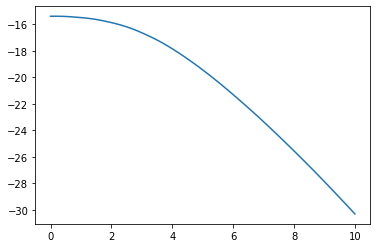

energy via QAE -> (-30.291376100358292+1.7763568394002505e-15j)


In [32]:
psi=initial_psi.copy()
energy=[]
for i,t in enumerate(time):
    hamiltonian_t=(1-t/tf)*DriverHamiltonian.hamiltonian+(t/tf)*NSMHamiltonian.hamiltonian
    energy.append(psi.conjugate().dot(hamiltonian_t.dot(psi)))
    
    psi=expm_multiply(-1j*dt*hamiltonian_t,psi)
    #psi=psi/np.linalg.norm(psi)
    

plt.plot(time,energy)
plt.show()

print('energy via QAE ->',energy[-1])    

#### Analysis of the magnitude of the Nuclear interaction (Not important)

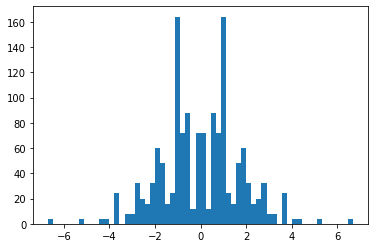

In [35]:
plt.hist(twobody_dict.values(),bins=60)
plt.show()

distance_measure=[]

for key in twobody_dict.keys():
    
    i,j,k,l=key
    distance_measure.append((np.sqrt((i-j)**2+(i-k)**2+(i-l)**2)))


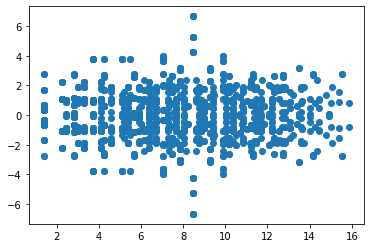

In [37]:
plt.scatter(distance_measure,twobody_dict.values())
plt.show()

[144  24 176 144 328  48  64  64 120  64  32  40  64  16  16  48   8   8
   8   8]


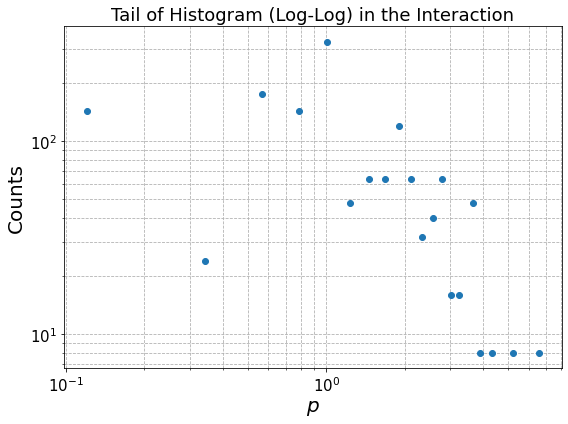

In [41]:
# Compute histogram (don't plot yet)
counts, bin_edges = np.histogram(np.abs(np.asarray(list(twobody_dict.values()))), bins=30,density=False)

# Bin centers (x-axis)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Filter out zero counts to avoid log(0)
nonzero = counts > 0
counts = counts[nonzero]

print(counts)
bin_centers = bin_centers[nonzero]
bin_widths = np.diff(bin_edges)

pdf = counts #/ (np.sum(counts))

# Plot in log-log scale
plt.figure(figsize=(8,6))
plt.loglog(bin_centers, pdf, marker='o', linestyle='none')
plt.xlabel(r'$p$', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.tick_params(labelsize=15)
plt.title(r"Tail of Histogram (Log-Log) in the Interaction", fontsize=18)
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()